# Solving the SSA without enforcing flotation

This notebook solves the version of the SSA found in Eq. 44 of [MacAyeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3), in which surface and basal elevations may be slightly out of flotational equilibrium. There is no time evolution (velocity and stress fields correspond to the input geometry only and do not approach steady state), rheology is linear, and I hard-code the vertical deflection $\eta$ instead of solving for it. The problem is solved first using pure Firedrake, and then the solution is verified with icepack. Good agreement between the two indicates that I'm modifying icepack correctly. 

## Method 1: just Firedrake

In their [linear elasticity tutorial](https://github.com/firedrakeproject/firedrake/blob/master/docs/notebooks/03-elasticity.ipynb), the variational form to be solved by Firedrake is written 

$$\int_\Omega \vec{\sigma} : \nabla\vec{v} d\Omega - \int_\Gamma (\vec{\sigma}\cdot\vec{n})\cdot\vec{v} d\Gamma = \int_\Omega \vec{f}\cdot \vec{v}d\Omega,$$

where the stress tensor $\vec{\sigma}$ relates to the displacement field via the standard constitutive relation for elastic materials. The SSA can be put directly into this form by substituting the depth-integrated net stress, $H\overline{\sigma}$, in place of $\vec{\sigma}$, and noting that the component of the body force acting along the $xy$ plane is zero. This yields the form

$$\int_\Omega H\overline{\sigma} : \nabla\vec{v}d\Omega - \int_\Gamma (H\overline{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma = 0.$$

We start by importing Firedrake and building a mesh:

In [1]:
from firedrake import *
import icepack.plot #iceplack.plot is the easiest way to plot firedrake's output
import matplotlib.pyplot as plt
import matplotlib.colors as colors 

length = 10000 #length of shelf (m)
width = 5000 #width of shelf (m)
H0 = 500 #thickness at terminus (m)
thick_grad = -0.01 #thickness gradient 
mesh = RectangleMesh(100, 50, length, width)

### Show the mesh
Comment out the last line to show the mesh.

In [2]:
coords = mesh.coordinates.dat.data
fig, ax = plt.subplots()
ax.triplot(coords[:,0], coords[:,1], color='k', linewidth=0.5)
plt.xlabel('x coordinate (m)', fontsize=16)
plt.ylabel('y coordinate (m)', fontsize=16)
plt.close() #comment this line out to actually show the plot

### Define function spaces, spatial variables

In [3]:
V = VectorFunctionSpace(mesh, 'CG', 2) #for interpolating vector functions (velocity, etc.)
Q = FunctionSpace(mesh, 'CG', 2) #scalar functions (surface elevation, etc.)
S = TensorFunctionSpace(mesh, 'DG', 1) #tensor functions (stress, etc.)

x, y = SpatialCoordinate(mesh)
i = as_vector([1, 0]) #basis vector in x
j = as_vector([0, 1]) #basis vector in y
Id = Identity(mesh.geometric_dimension()) #2x2 identity matrix

### Physical constants and spatial parameters
Choosing values consistent with icepack's, with the caveat that icepack uses different units. 

In [4]:
ρ_i = Constant(917) #density of ice (kg/m^3)
ρ_w = Constant(1024) #density of seawater (kg/m^3)
g = Constant(9.81) #gravity (m/s^2)
μ = Constant(6e13) #somewhat arbitrary viscosity (Pa*s)
from icepack.constants import year #number of seconds per year

H = interpolate(thick_grad*(x - length) + H0, Q) #thickness is H0 at terminus, increases linearly upstream

### Choose Dirichlet boundary conditions
Define several possible boundary conditions here, and then choose the ones we actually want to use.

In [5]:
sidewalls_y = DirichletBC(V.sub(1), Constant(0), (3, 4)) #no lateral motion through sidewalls
sidewalls_x = DirichletBC(V.sub(0), Constant(0), (3, 4)) #no slip along sidewalls
upstream_y = DirichletBC(V.sub(1), Constant(0), 1) #no lateral motion at the upstream boundary
upstream_x = DirichletBC(V.sub(0), Constant(0), 1) #no longitudinal motion at the upstream boundary

bcs = [upstream_x, upstream_y, sidewalls_x, sidewalls_y] #modify this to solve a different problem

### Is the shelf at flotation?

We'll simulate periodic, flow-perpendicular "rumples." Vertical deflection will vary as a sine wave with frequency ```freq``` and amplitude ```amp```. Solve the classic SSA by setting ```amp = 0```.

Text(0.5, 1.0, 'vertical deflection η')

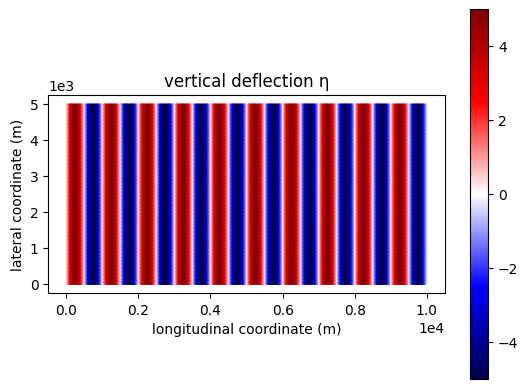

In [6]:
amp = 5 #max vertical deflection in meters (should not ever be more than a few % of the ice thickness)
freq = 10 #total number of rumples we want 
η = interpolate(amp*sin(freq*2*pi*x/length), Q) 

s = interpolate((1 - ρ_i/ρ_w)*H + η, Q) #surface elevation is η meters above its flotation height
b = interpolate(-ρ_i/ρ_w*H + η, Q) #basal elevation

#Here I'll define a plotting function
def plot(item, plotting_module = icepack.plot.tricontourf, cmap = 'Reds', norm = False):
    item = interpolate(item, Q)
    fig, axes = icepack.plot.subplots()
    norm = colors.TwoSlopeNorm(vcenter = 0)
    if norm:
        theplot = plotting_module(item, axes = axes, cmap = cmap, norm = norm)
    else:
        theplot = plotting_module.plot.tripcolor(item, axes = axes, cmap = cmap)
    fig.colorbar(theplot)
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    
plot(η, plotting_module = icepack.plot.tripcolor, cmap = 'seismic', norm = True)
plt.title('vertical deflection η')

### Constitutive relation

The trick to making the linear elasticity tutorial work for the SSA is the writing of the constitutive relation. Toward writing this relationship, note first that

$$H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \int_b^s\rho_ig(s-z)dz\vec{I} - \int_b^0\rho_wgzdz\vec{I},$$

where the first term on the right can be physically interpreted as the depth-integrated resistive stress tensor, and the integral terms represent the weight of the ice and water columns. It follows that 

$$H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \frac{1}{2}\rho_igH^2\vec{I} + \frac{1}{2}\rho_wgb^2\vec{I}.$$

In the special case of perfect flotation, $b = -\frac{\rho_i}{\rho_w}H$, and the above relationship would simplify to 

$$ H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \frac{1}{2}\rho_i gsH\vec{I}.$$

(This relationship can be naturally enforced by setting the wave amplitude ```amp = 0``` in the cell above.) In the more general formulation, the variational form in the preamble can now be expressed

$$ \int_\Omega \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u}^T) + 2(\nabla\cdot\vec{u})^T\vec{I}\right):\nabla\vec{v}d\Omega = \int_\Gamma(H\overline{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma + \int_{\Omega}\left(\frac{1}{2}\rho_i gH^2\vec{I} - \frac{1}{2}\rho_wgb^2\vec{I}\right):\nabla\vec{v}d\Omega$$



In [7]:
def HR(u): #physically interpreted as the depth-integrated resistive stress tensor, a la van der Veen
    return μ*H*(grad(u) + grad(u).T + 2*div(u)*Id)     

### Solve the variational problem

In [8]:
u = TrialFunction(V)
v = TestFunction(V)
a = inner(HR(u), grad(v))*dx 
L = inner(1/2*ρ_i*g*H**2*Id - 1/2*ρ_w*g*b**2*Id, grad(v))*dx #if applicable, add any Neumann BCs to L
#(no need to add the terminal cliff BC here because it's a zero-traction boundary condition anyway)

u_fd = Function(V) #velocity solution (u_x, u_y) from (f)ire(d)rake
solve(a == L,
        u_fd,
        bcs = bcs,
        solver_parameters = {'ksp_monitor':None})

τ_fd = interpolate(μ*grad(u_fd) + μ*grad(u_fd).T, S) #deviatoric stress tensor
τxx_fd = interpolate(dot(dot(τ_fd, i), i)/1000, Q) #dividing by 1000 to get τ_xx in kPa
τyy_fd = interpolate(dot(dot(τ_fd, j), j)/1000, Q) #τ_yy
τxy_fd = interpolate(dot(dot(τ_fd, i), j)/1000, Q) #τ_xy
τe_fd = interpolate(sqrt(τxx_fd**2 + τyy_fd**2 + 2*τxy_fd**2), Q) #effective stress τ_e
ux_fd = interpolate(dot(u_fd, i)*year, Q) #multiplying by 31557600 to get u_x in m/yr
uy_fd = interpolate(dot(u_fd, j)*year, Q) #u_y in meters per year

    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 7.474916331581e+10 
    1 KSP Residual norm 2.034426224474e-02 


### Visualize the results

Text(0.5, 1.0, 'firedrake velocity solution (m/yr)')

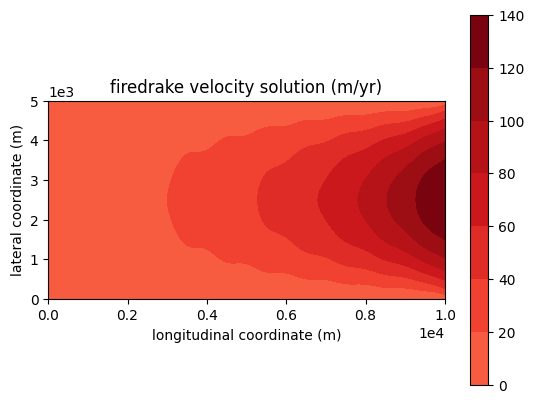

In [9]:
item = ux_fd #the item we want to plot

plot(item)
title = 'velocity solution (m/yr)' if (item == ux_fd or item == uy_fd) else 'deviatoric stress solution (kPa)'
plt.title('firedrake {}'.format(title))

## Method 2: icepack

In [10]:
import icepack
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as G #icepack uses different units!
from operator import itemgetter

### Modify icepack's viscosity to allow $n = 1$; modify gravity and terminus to allow $\eta \neq 0$

In [11]:
def viscosity2(**kwargs):
    n = 1 #don't try to change this without also changing A
    A = 1/(2*μ)*1e6*icepack.constants.year #get A in /(MPa*yr) consistent with μ in Pa*s
    u, h = itemgetter('velocity', 'thickness')(kwargs)
    e_min = kwargs.get('strain_rate_min', Constant(icepack.constants.strain_rate_min))
    e = icepack.calculus.sym_grad(u)
    e_e = icepack.models.viscosity._effective_strain_rate(e, e_min)
    
    return 2*n/(n+1)*h*A**(-1/n)*e_e**(1/n+1)


def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021), but note the sign error!
    u, h = itemgetter("velocity", "thickness")(kwargs)
    
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)


def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h = itemgetter("velocity", "thickness")(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

### Choose boundary conditions

In [12]:
#boundary labels: (upstream, downstream, right, left) = (1, 2, 3, 4)
dirichlet_ids = [1, 3, 4]
side_wall_ids = []
ice_front_ids = [2]

### Define the model and solver

In [13]:
model = icepack.models.IceShelf(viscosity = viscosity2, gravity = gravity2, terminus = terminus2,
                               side_friction = icepack.models.friction.side_friction)

solver = icepack.solvers.FlowSolver(model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

### Solve with icepack

In [14]:
u0 = interpolate(as_vector([1e-50, 1e-50]), V) #1e-50 rather than zero, to avoid a singularity in side friction
C0 = Constant(0.0) #coefficient of sidewall friction for slippery sidewalls

u_ip = solver.diagnostic_solve(velocity = u0, side_friction = C0, thickness = H)

τ_ip = interpolate(μ*grad(u_ip) + μ*grad(u_ip).T, S) #deviatoric stress tensor
τxx_ip = interpolate(dot(dot(τ_ip, i), i)/(icepack.constants.year*1e3), Q) #τ_xx in kPa
τyy_ip = interpolate(dot(dot(τ_ip, j), j)/(icepack.constants.year*1e3), Q) #τ_yy in kPa
τxy_ip = interpolate(dot(dot(τ_ip, i), j)/(icepack.constants.year*1e3), Q) #τ_xy in kPa
τe_ip = interpolate(sqrt(τxx_ip**2 + τyy_ip**2 + 2*τxy_ip**2), Q) #τ_e in kPa
ux_ip = interpolate(dot(u_ip, i), Q) #u_x
uy_ip = interpolate(dot(u_ip, j), Q) #u_y

### And plot the icepack solution 

Text(0.5, 1.0, 'icepack velocity solution (m/yr)')

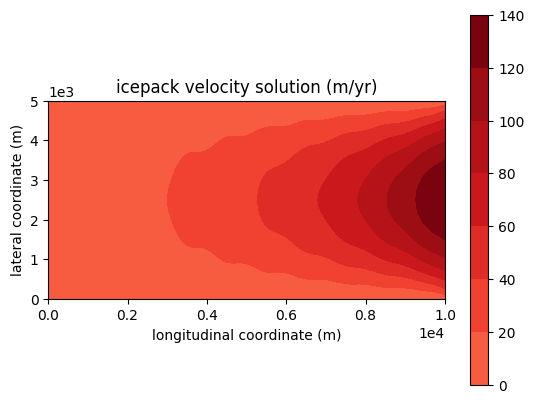

In [15]:
item = ux_ip #the item we want to plot

plot(item)
title = 'velocity solution (m/yr)' if (item == ux_ip or item == uy_ip) else 'deviatoric stress solution (kPa)'
plt.title('icepack {}'.format(title))

## Do the two solutions agree?

Text(0.5, 1.0, 'firedrake vs. icepack diff (m/yr)')

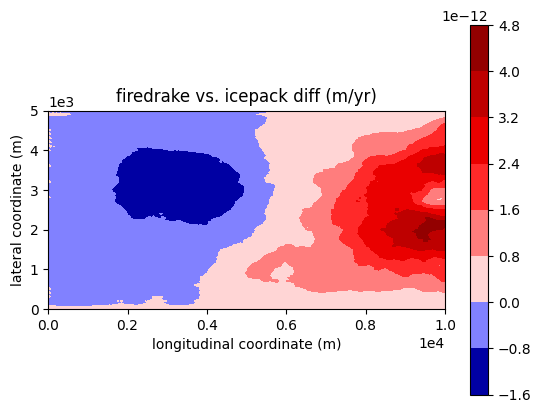

In [16]:
items = (ux_fd, ux_ip) #the two outputs we want to compare

plot(items[1] - items[0], cmap = 'seismic', norm = True)
units = '(m/yr)' if (ux_fd in items or uy_fd in items) else '(kPa)'
plt.title('firedrake vs. icepack diff {}'.format(units))

### If solving uniaxial extension, also compare with analytic solution

For a longitudinally extending shelf in flotational equilibrium, $\tau_{xx} = \frac{1}{4}\rho_igs(x)$. We can generalize this relationship to also describe the shelf in non-equilibrium:

$$ \tau_{xx} = \frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wgb^2$$

Simulate a longitudinally extending shelf with Firedrake by setting ```bcs = [upstream_x, upstream_y, sidewalls_y]```, and with icepack by setting ```dirichlet_ids = [1]```, ```side_wall_ids = [3, 4]```, and ```ice_front_ids = [2]```.

In [17]:
# analytic_general = interpolate((1/4*ρ_i*g*H - 1/4*ρ_w*g*b**2/H)/1000, Q) 
# analytic_floating = interpolate(1/4*ρ_i*g*(1 - ρ_i/ρ_w)*H/1000, Q) #if we want a baseline to compare with

# plot(τxx_fd - analytic_general, plotting_module = icepack.plot.tripcolor, cmap = 'seismic', norm = True)
# plt.title('stress solution diff (kPa)')